In [6]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37599")
client

<Client: 'tcp://127.0.0.1:37599' processes=10 threads=30, memory=267.91 GiB>

In [1]:
import numpy as np
import qgutils
import xarray as xr
# import zarr
# import shutil
# from rechunker import rechunk
import dask.array as dsar
import os.path as op
# import scipy.sparse as spar
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [2]:
ddir = '/bettik/uchidat/qg-ML/'

In [3]:
U     = .1
T     = 5e5    # seconds
L     = U*T
tau0  = .0001
dt    = 5e-2
Rd    = 5e4   # Rossby radius (50km)
Re4   = 4e3
# f0 = 8e-5
beta  = .5
N     = 1024   # Number of horizontal grids
L0    = 80
H     = 5e3
dx    = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny  = 360
Rom   = .025
Ekb   = .002*2
ntime = int(62.2*5)+1

percent = 10
nmemb = 100

ncoars = 4
DX = dx * ncoars

In [4]:
dsb1 = xr.open_dataset(op.join(ddir,"Mean-n04_001.nc")).chunk({'time':9,'YC':128,'XC':128})
dsb1

,Array,Chunk
Bytes,237.67 MiB,1.69 MiB
Shape,"(312, 3, 258, 258)","(9, 3, 128, 128)"
Count,316 Tasks,315 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,237.67 MiB,1.69 MiB
Shape,"(312, 3, 258, 258)","(9, 3, 128, 128)"
Count,316 Tasks,315 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [5]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    # if nd == 2:
    #     psi = np.pad(psi,((1,1),(1,1)),'constant')
    if nd < 4:
        psi = qgutils.pad_bc(psi)
    elif nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def _dot2D(self, other):
    func = np.dot(self[0,0], other[0,0])
    
    return func[np.newaxis,np.newaxis,:,:]

In [7]:
P0 = dsb1.P0b.data   
P0x = np.diff(P0[...,1:-1,:], axis=-1) / DX
P0x = xr.DataArray(.5*(P0x[...,1:] + P0x[...,:-1]), 
                   dims=dsb1.P0b.dims, 
                   coords=dsb1.P0b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P0y = np.diff(P0[...,1:-1], axis=-2) / DX
P0y = xr.DataArray(.5*(P0y[...,1:,:] + P0y[...,:-1,:]), 
                   dims=dsb1.P0b.dims, 
                   coords=dsb1.P0b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

P1 = dsb1.P1b.data
P1x = np.diff(P1[...,1:-1,:], axis=-1) / DX
P1x = xr.DataArray(.5*(P1x[...,1:] + P1x[...,:-1]), 
                   dims=dsb1.P1b.dims, 
                   coords=dsb1.P1b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P1y = np.diff(P1[...,1:-1], axis=-2) / DX
P1y = xr.DataArray(.5*(P1y[...,1:,:] + P1y[...,:-1,:]), 
                   dims=dsb1.P1b.dims, 
                   coords=dsb1.P1b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

P2 = dsb1.P2b.data
P2x = np.diff(P2[...,1:-1,:], axis=-1) / DX
P2x = xr.DataArray(.5*(P2x[...,1:] + P2x[...,:-1]), 
                   dims=dsb1.P2b.dims, 
                   coords=dsb1.P2b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P2y = np.diff(P2[...,1:-1], axis=-2) / DX
P2y = xr.DataArray(.5*(P2y[...,1:,:] + P2y[...,:-1,:]), 
                   dims=dsb1.P2b.dims, 
                   coords=dsb1.P2b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

P3 = dsb1.P3b.data  
P3x = np.diff(P3[...,1:-1,:], axis=-1) / DX
P3x = xr.DataArray(.5*(P3x[...,1:] + P3x[...,:-1]), 
                   dims=dsb1.P3b.dims, 
                   coords=dsb1.P3b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P3y = np.diff(P3[...,1:-1], axis=-2) / DX
P3y = xr.DataArray(.5*(P3y[...,1:,:] + P3y[...,:-1,:]), 
                   dims=dsb1.P3b.dims, 
                   coords=dsb1.P3b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

Q = dsb1.qb.data   
Qx = np.diff(Q[...,1:-1,:], axis=-1) / DX
Qx = xr.DataArray(.5*(Qx[...,1:] + Qx[...,:-1]), 
                  dims=dsb1.qb.dims, 
                  coords=dsb1.qb.isel(YC=slice(1,-1),
                                      XC=slice(1,-1)).coords
                 ).chunk({'YC':128,'XC':128})
Qy = np.diff(Q[...,1:-1], axis=-2) / DX
Qy = xr.DataArray(.5*(Qy[...,1:,:] + Qy[...,:-1,:]), 
                  dims=dsb1.qb.dims, 
                  coords=dsb1.qb.isel(YC=slice(1,-1),
                                      XC=slice(1,-1)).coords
                 ).chunk({'YC':128,'XC':128})

/tmp/ipykernel_695501/1812127244.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(P0x.XC*L*1e-3, P0x.YC*L*1e-3, P0x.isel(time=0,Z=1),
/tmp/ipykernel_695501/1812127244.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(P0y.XC*L*1e-3, P0y.YC*L*1e-3, P0y.isel(time=0,Z=1),
/tmp/ipykernel_695501/1812127244.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated 

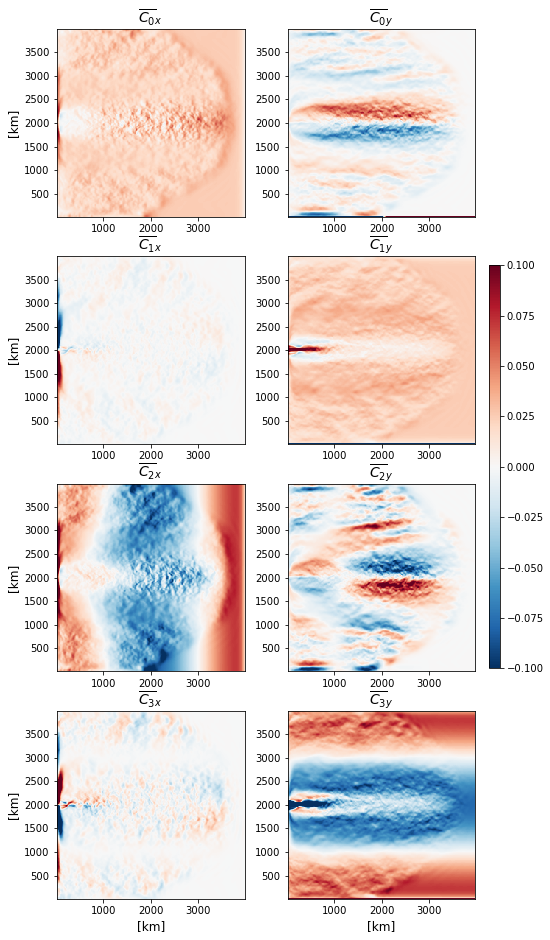

In [15]:
fig, axes = plt.subplots(figsize=(8,16), nrows=4, ncols=2)

im = axes[0,0].pcolormesh(P0x.XC*L*1e-3, P0x.YC*L*1e-3, P0x.isel(time=0,Z=1), 
                          cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[0,1].pcolormesh(P0y.XC*L*1e-3, P0y.YC*L*1e-3, P0y.isel(time=0,Z=1), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[1,0].pcolormesh(P1x.XC*L*1e-3, P1x.YC*L*1e-3, P1x.isel(time=0,Z=1), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[1,1].pcolormesh(P1y.XC*L*1e-3, P1y.YC*L*1e-3, P1y.isel(time=0,Z=1), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[2,0].pcolormesh(P2x.XC*L*1e-3, P2x.YC*L*1e-3, P2x.isel(time=0,Z=1), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[2,1].pcolormesh(P2y.XC*L*1e-3, P2y.YC*L*1e-3, P2y.isel(time=0,Z=1), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[3,0].pcolormesh(P3x.XC*L*1e-3, P3x.YC*L*1e-3, P3x.isel(time=0,Z=1), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[3,1].pcolormesh(P3y.XC*L*1e-3, P3y.YC*L*1e-3, P3y.isel(time=0,Z=1), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
# axes[4,0].pcolormesh(Qx.XC*L*1e-3,  Qx.YC*L*1e-3,  Qx.isel(time=0,Z=1), 
#                      cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
# axes[4,1].pcolormesh(Qy.XC*L*1e-3,  Qy.YC*L*1e-3,  Qy.isel(time=0,Z=1), 
#                      cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)

axes[0,0].set_title(r"$\overline{C_0}_x$", fontsize=14)
axes[0,1].set_title(r"$\overline{C_0}_y$", fontsize=14)
axes[1,0].set_title(r"$\overline{C_1}_x$", 
                    fontsize=14)
axes[1,1].set_title(r"$\overline{C_1}_y$", 
                    fontsize=14)
axes[2,0].set_title(r"$\overline{C_2}_x$", 
                    fontsize=14)
axes[2,1].set_title(r"$\overline{C_2}_y$", 
                    fontsize=14)
axes[3,0].set_title(r"$\overline{C_3}_x$", 
                    fontsize=14)
axes[3,1].set_title(r"$\overline{C_3}_y$", 
                    fontsize=14)
# axes[4,0].set_title(r"$\overline{q}_x$", 
#                     fontsize=14)
# axes[4,1].set_title(r"$\overline{q}_y$", 
#                     fontsize=14)

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)
axes[2,0].set_aspect(1)
axes[2,1].set_aspect(1)
axes[3,0].set_aspect(1)
axes[3,1].set_aspect(1)
# axes[4,0].set_aspect(1)
# axes[4,1].set_aspect(1)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[2,0].set_ylabel(r"[km]", fontsize=12)
axes[3,0].set_ylabel(r"[km]", fontsize=12)
# axes[4,0].set_ylabel(r"[km]", fontsize=12)
axes[3,0].set_xlabel(r"[km]", fontsize=12)
axes[3,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.21)
cbax = fig.add_axes([.88, .325, .018, .35])
cbar = fig.colorbar(im, cax=cbax)

plt.savefig(op.join(ddir,'Figs/GradMeanPtr_Z=%1d_%010d.pdf' % (1,0)))

/tmp/ipykernel_695501/94497810.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0].pcolormesh(Qx.XC*L*1e-3,  Qx.YC*L*1e-3,  Qx.isel(time=0,Z=1),
/tmp/ipykernel_695501/94497810.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1].pcolormesh(Qy.XC*L*1e-3,  Qy.YC*L*1e-3,  Qy.isel(time=0,Z=1),


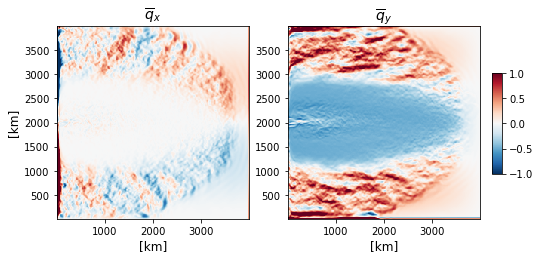

In [20]:
fig, axes = plt.subplots(figsize=(8,4), nrows=1, ncols=2)

im = axes[0].pcolormesh(Qx.XC*L*1e-3,  Qx.YC*L*1e-3,  Qx.isel(time=0,Z=1), 
                     cmap='RdBu_r', vmin=-1., vmax=1., rasterized=True)
axes[1].pcolormesh(Qy.XC*L*1e-3,  Qy.YC*L*1e-3,  Qy.isel(time=0,Z=1), 
                     cmap='RdBu_r', vmin=-1., vmax=1., rasterized=True)


axes[0].set_title(r"$\overline{q}_x$", 
                    fontsize=14)
axes[1].set_title(r"$\overline{q}_y$", 
                    fontsize=14)

axes[0].set_aspect(1)
axes[1].set_aspect(1)


axes[0].set_ylabel(r"[km]", fontsize=12)
axes[0].set_xlabel(r"[km]", fontsize=12)
axes[1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.21)
cbax = fig.add_axes([.88, .325, .018, .35])
cbar = fig.colorbar(im, cax=cbax)

plt.savefig(op.join(ddir,'Figs/GradMeanQ_Z=%1d_%010d.pdf' % (1,0)))

/tmp/ipykernel_695501/1238885510.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(P0x.XC*L*1e-3, P0x.YC*L*1e-3, P0x.isel(time=0,Z=2),
/tmp/ipykernel_695501/1238885510.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(P0y.XC*L*1e-3, P0y.YC*L*1e-3, P0y.isel(time=0,Z=2),
/tmp/ipykernel_695501/1238885510.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated 

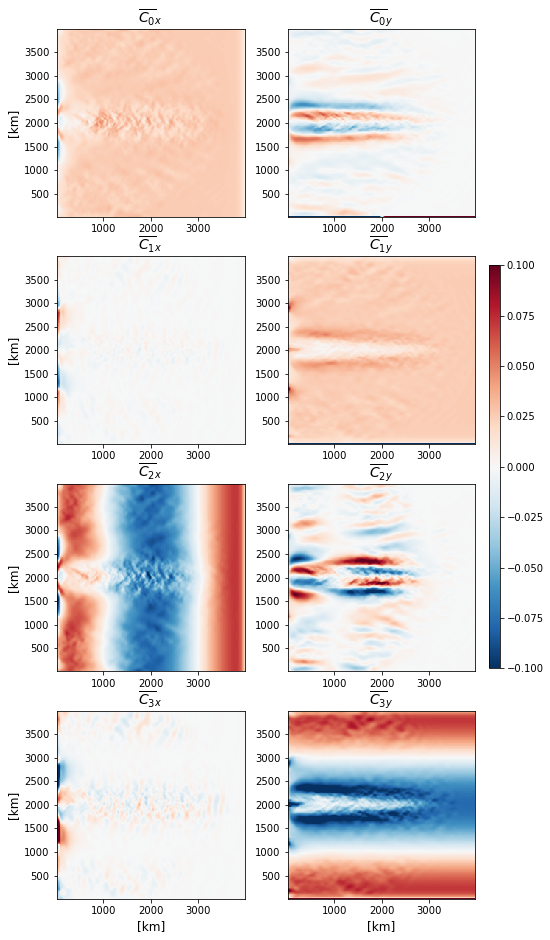

In [18]:
fig, axes = plt.subplots(figsize=(8,16), nrows=4, ncols=2)

im = axes[0,0].pcolormesh(P0x.XC*L*1e-3, P0x.YC*L*1e-3, P0x.isel(time=0,Z=2), 
                          cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[0,1].pcolormesh(P0y.XC*L*1e-3, P0y.YC*L*1e-3, P0y.isel(time=0,Z=2), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[1,0].pcolormesh(P1x.XC*L*1e-3, P1x.YC*L*1e-3, P1x.isel(time=0,Z=2), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[1,1].pcolormesh(P1y.XC*L*1e-3, P1y.YC*L*1e-3, P1y.isel(time=0,Z=2), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[2,0].pcolormesh(P2x.XC*L*1e-3, P2x.YC*L*1e-3, P2x.isel(time=0,Z=2), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[2,1].pcolormesh(P2y.XC*L*1e-3, P2y.YC*L*1e-3, P2y.isel(time=0,Z=2), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[3,0].pcolormesh(P3x.XC*L*1e-3, P3x.YC*L*1e-3, P3x.isel(time=0,Z=2), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
axes[3,1].pcolormesh(P3y.XC*L*1e-3, P3y.YC*L*1e-3, P3y.isel(time=0,Z=2), 
                     cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
# axes[4,0].pcolormesh(Qx.XC*L*1e-3,  Qx.YC*L*1e-3,  Qx.isel(time=0,Z=1), 
#                      cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)
# axes[4,1].pcolormesh(Qy.XC*L*1e-3,  Qy.YC*L*1e-3,  Qy.isel(time=0,Z=1), 
#                      cmap='RdBu_r', vmin=-.1, vmax=.1, rasterized=True)

axes[0,0].set_title(r"$\overline{C_0}_x$", fontsize=14)
axes[0,1].set_title(r"$\overline{C_0}_y$", fontsize=14)
axes[1,0].set_title(r"$\overline{C_1}_x$", 
                    fontsize=14)
axes[1,1].set_title(r"$\overline{C_1}_y$", 
                    fontsize=14)
axes[2,0].set_title(r"$\overline{C_2}_x$", 
                    fontsize=14)
axes[2,1].set_title(r"$\overline{C_2}_y$", 
                    fontsize=14)
axes[3,0].set_title(r"$\overline{C_3}_x$", 
                    fontsize=14)
axes[3,1].set_title(r"$\overline{C_3}_y$", 
                    fontsize=14)
# axes[4,0].set_title(r"$\overline{q}_x$", 
#                     fontsize=14)
# axes[4,1].set_title(r"$\overline{q}_y$", 
#                     fontsize=14)

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)
axes[2,0].set_aspect(1)
axes[2,1].set_aspect(1)
axes[3,0].set_aspect(1)
axes[3,1].set_aspect(1)
# axes[4,0].set_aspect(1)
# axes[4,1].set_aspect(1)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[2,0].set_ylabel(r"[km]", fontsize=12)
axes[3,0].set_ylabel(r"[km]", fontsize=12)
# axes[4,0].set_ylabel(r"[km]", fontsize=12)
axes[3,0].set_xlabel(r"[km]", fontsize=12)
axes[3,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.21)
cbax = fig.add_axes([.88, .325, .018, .35])
cbar = fig.colorbar(im, cax=cbax)

plt.savefig(op.join(ddir,'Figs/GradMeanPtr_Z=%1d_%010d.pdf' % (2,0)))

/tmp/ipykernel_695501/844570779.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0].pcolormesh(Qx.XC*L*1e-3,  Qx.YC*L*1e-3,  Qx.isel(time=0,Z=2),
/tmp/ipykernel_695501/844570779.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1].pcolormesh(Qy.XC*L*1e-3,  Qy.YC*L*1e-3,  Qy.isel(time=0,Z=2),


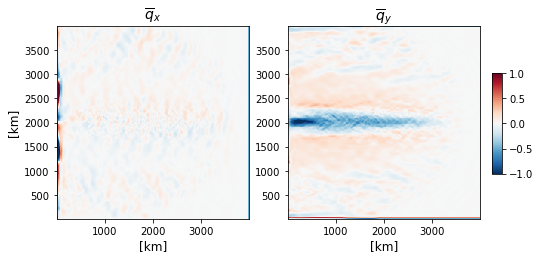

In [21]:
fig, axes = plt.subplots(figsize=(8,4), nrows=1, ncols=2)

im = axes[0].pcolormesh(Qx.XC*L*1e-3,  Qx.YC*L*1e-3,  Qx.isel(time=0,Z=2), 
                     cmap='RdBu_r', vmin=-1., vmax=1., rasterized=True)
axes[1].pcolormesh(Qy.XC*L*1e-3,  Qy.YC*L*1e-3,  Qy.isel(time=0,Z=2), 
                     cmap='RdBu_r', vmin=-1., vmax=1., rasterized=True)


axes[0].set_title(r"$\overline{q}_x$", 
                    fontsize=14)
axes[1].set_title(r"$\overline{q}_y$", 
                    fontsize=14)

axes[0].set_aspect(1)
axes[1].set_aspect(1)


axes[0].set_ylabel(r"[km]", fontsize=12)
axes[0].set_xlabel(r"[km]", fontsize=12)
axes[1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.21)
cbax = fig.add_axes([.88, .325, .018, .35])
cbar = fig.colorbar(im, cax=cbax)

plt.savefig(op.join(ddir,'Figs/GradMeanQ_Z=%1d_%010d.pdf' % (2,0)))